# 03 - Modelos de Forecasting

**Proyecto:** Forecast Promtur - Tráfico Orgánico  
**Objetivo:** Generar predicciones de métricas para 2026 usando Prophet

---

## Contenido:
1. Carga del dataset procesado
2. Preparación de datos para Prophet
3. Análisis de series temporales
4. Modelos de forecasting por canal
5. Evaluación de resultados
6. Visualización de predicciones 2026
7. Exportación de resultados

## 1. Configuración inicial y librerías

In [41]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from prophet import Prophet
from datetime import datetime, timedelta
import json

# Ignorar warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


## 2. Carga del dataset procesado

In [42]:
# Definir rutas del proyecto
DATA_PROCESSED = Path('../data/processed')
DATA_FORECASTS = Path('../data/forecasts')
MODELS_DIR = Path('../models')
RESULTS_FIGURES = Path('../results/figures/forecasts')
RESULTS_REPORTS = Path('../results/reports')

# Crear carpetas si no existen
DATA_FORECASTS.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_FIGURES.mkdir(parents=True, exist_ok=True)
RESULTS_REPORTS.mkdir(parents=True, exist_ok=True)

# Cargar dataset limpio
dataset_file = DATA_PROCESSED / 'dataset_clean.csv'

if dataset_file.exists():
    df = pd.read_csv(dataset_file)
    print(f"✅ Dataset limpio cargado exitosamente")
    print(f"📊 Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
else:
    print(f"❌ Error: No se encontró el archivo {dataset_file}")
    print(f"📁 Ejecuta primero el Notebook 02 para generar el dataset limpio")

✅ Dataset limpio cargado exitosamente
📊 Dimensiones: 22 filas x 10 columnas


In [43]:
# Mostrar estructura del dataset
print("📋 Estructura del dataset:\n")
df.head(10)

📋 Estructura del dataset:



,year,month,channel,sessions,bounces,total_session_duration,views,bounce_rate,views_per_session,avg_session_duration
0,2025,1,AI Traffic,135,7,20650,199,5.19,1.47,152.96
1,2025,1,Organic Search,100968,7292,22689260,191522,7.22,1.90,224.72
2,2025,2,AI Traffic,192,6,35354,323,3.12,1.68,184.14
3,2025,2,Organic Search,86584,3778,19970939,165464,4.36,1.91,230.65
4,2025,3,AI Traffic,188,52,31920,270,27.66,1.44,169.79
5,2025,3,Organic Search,83571,15134,17858226,151896,18.11,1.82,213.69
6,2025,4,AI Traffic,257,67,44575,343,26.07,1.33,173.44
7,2025,4,Organic Search,74501,14179,18271205,133343,19.03,1.79,245.25
8,2025,5,AI Traffic,193,5,37696,280,2.59,1.45,195.32
9,2025,5,Organic Search,67974,3401,15803860,122222,5.00,1.80,232.50


In [44]:
# Información del dataset
print("ℹ️ Información del dataset:\n")
print(f"Canales: {sorted(df['channel'].unique())}")
print(f"Período: {df['year'].min()}-{df['month'].min()} a {df['year'].max()}-{df['month'].max()}")
print(f"Total de meses: {df[['year', 'month']].drop_duplicates().shape[0]}")

ℹ️ Información del dataset:

Canales: ['AI Traffic', 'Organic Search']
Período: 2025-1 a 2025-11
Total de meses: 11


## 3. Preparación de datos para Prophet

Prophet requiere un DataFrame con columnas específicas:
- `ds`: Fecha (datetime)
- `y`: Valor a predecir (numérico)

In [45]:
# Crear columna de fecha
df['ds'] = pd.to_datetime(
    df['year'].astype(str) + '-' + df['month'].astype(str) + '-01'
)

print("✅ Columna de fecha 'ds' creada para Prophet")
print(f"\nRango de fechas: {df['ds'].min()} a {df['ds'].max()}")

✅ Columna de fecha 'ds' creada para Prophet

Rango de fechas: 2025-01-01 00:00:00 a 2025-11-01 00:00:00


In [46]:
# ===================================================================
# CONFIGURACIÓN: Métricas y canales para forecasting
# ===================================================================

# Métricas a predecir (sin 'users' por ahora)
metricas_forecast = [
    'sessions',
    'bounce_rate',
    'views_per_session',
    'avg_session_duration'
]

# Canales a analizar (automático: todos los canales del dataset)
canales = sorted(df['channel'].unique())

# Horizonte de predicción: 12 meses (todo 2026)
periodos_forecast = 12

print(f"📊 Configuración de forecasting:")
print(f"\nMétricas a predecir: {len(metricas_forecast)}")
for metrica in metricas_forecast:
    print(f"   - {metrica}")

print(f"\nCanales a analizar: {len(canales)}")
for canal in canales:
    print(f"   - {canal}")

print(f"\nHorizonte de predicción: {periodos_forecast} meses (todo 2026)")
print(f"\nTotal de modelos a entrenar: {len(metricas_forecast)} métricas × {len(canales)} canales = {len(metricas_forecast) * len(canales)} modelos")

📊 Configuración de forecasting:

Métricas a predecir: 4
   - sessions
   - bounce_rate
   - views_per_session
   - avg_session_duration

Canales a analizar: 2
   - AI Traffic
   - Organic Search

Horizonte de predicción: 12 meses (todo 2026)

Total de modelos a entrenar: 4 métricas × 2 canales = 8 modelos


## 4. Análisis visual de series temporales

Antes de hacer forecasting, visualicemos las series temporales de cada métrica por canal.


📈 Gráfico: Sesiones


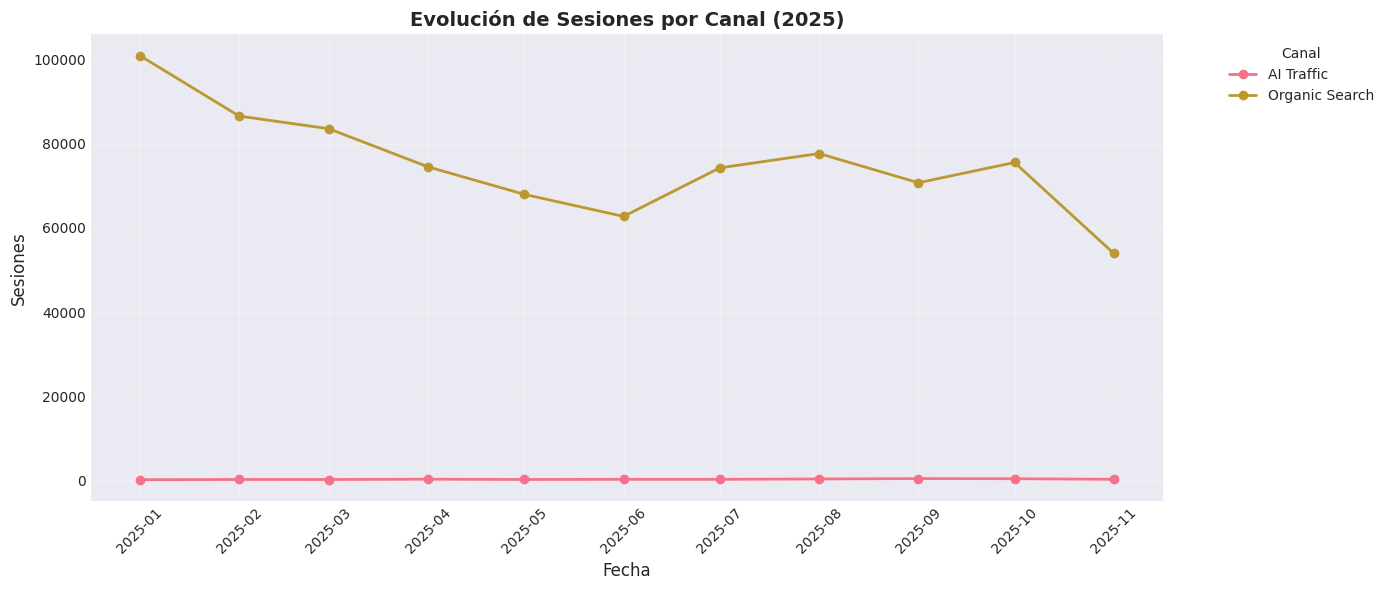


📈 Gráfico: Bounce Rate (%)


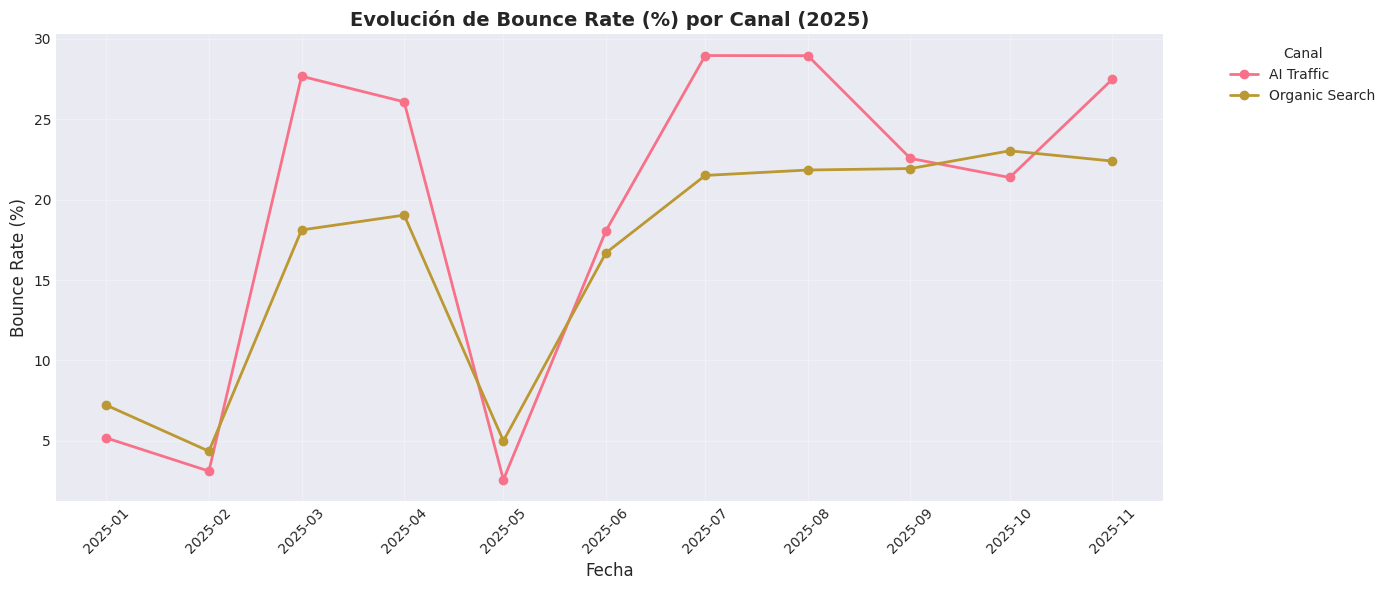


📈 Gráfico: Vistas por Sesión


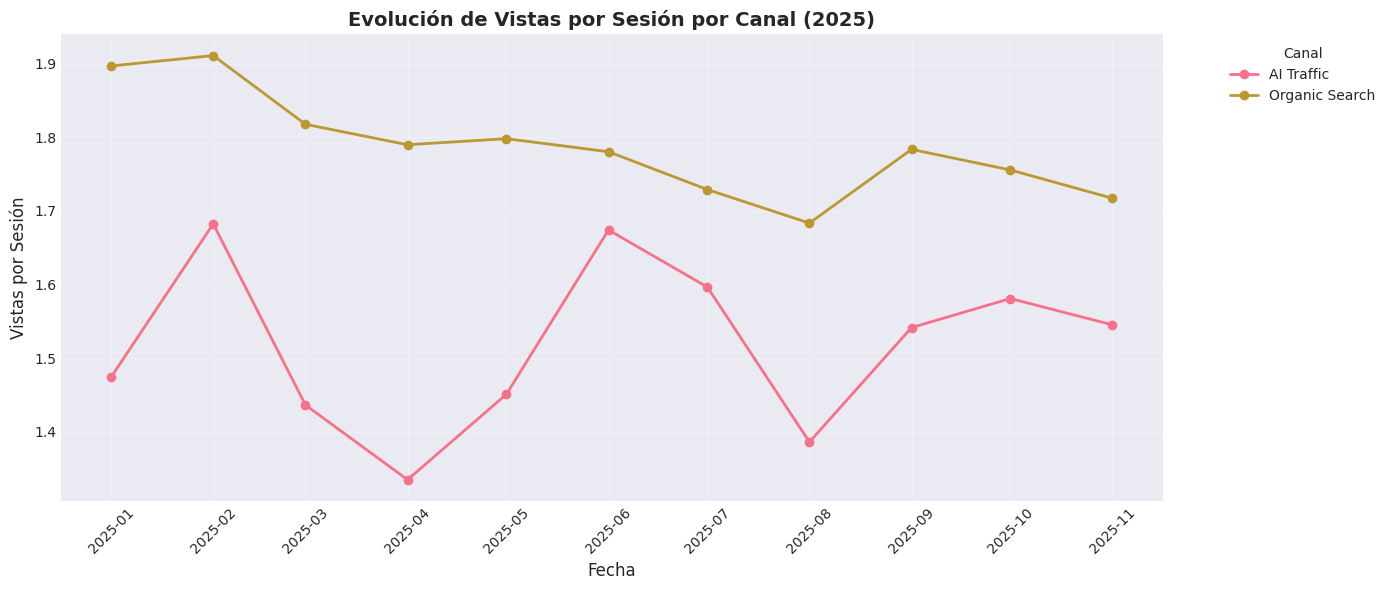


📈 Gráfico: Duración Promedio (segundos)


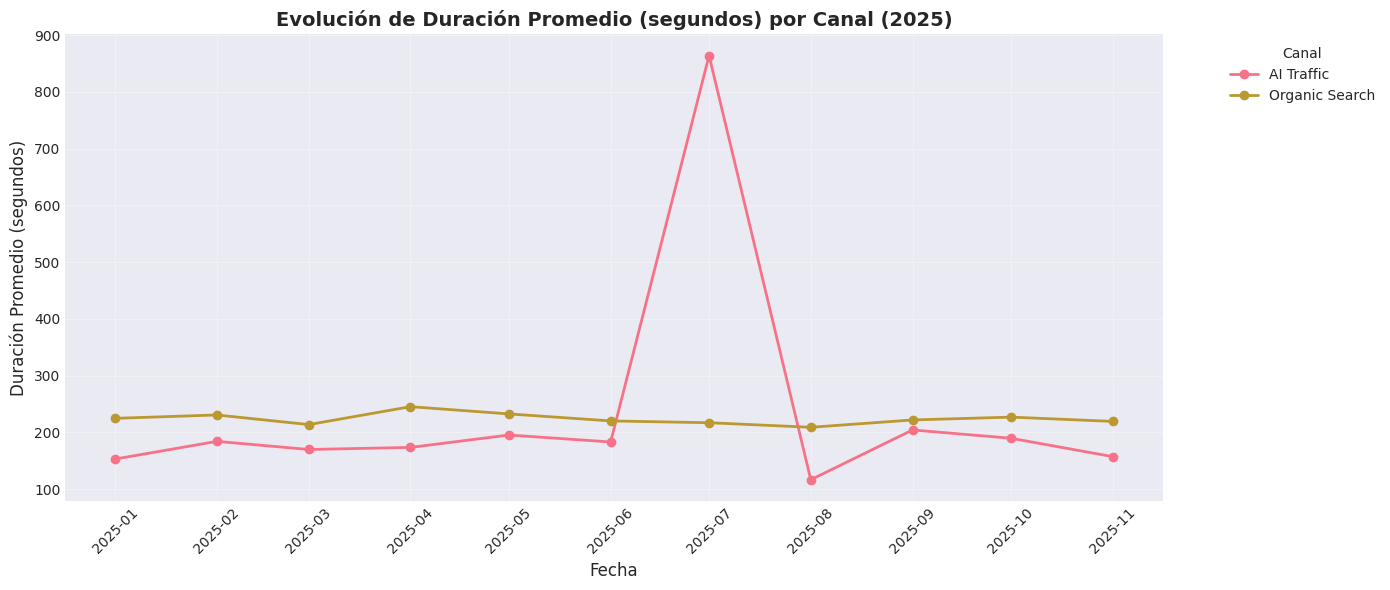

In [47]:
# Función para visualizar series temporales
def plot_series_temporales(df, metrica, titulo):
    """
    Grafica la evolución temporal de una métrica para todos los canales
    """
    fig, ax = plt.subplots(figsize=(14, 6))
    
    for canal in sorted(df['channel'].unique()):
        data_canal = df[df['channel'] == canal].sort_values('ds')
        ax.plot(data_canal['ds'], data_canal[metrica], 
                marker='o', label=canal, linewidth=2, markersize=6)
    
    ax.set_xlabel('Fecha', fontsize=12)
    ax.set_ylabel(titulo, fontsize=12)
    ax.set_title(f'Evolución de {titulo} por Canal (2025)', fontsize=14, fontweight='bold')
    ax.legend(title='Canal', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Visualizar cada métrica
metricas_titulos = {
    'sessions': 'Sesiones',
    'bounce_rate': 'Bounce Rate (%)',
    'views_per_session': 'Vistas por Sesión',
    'avg_session_duration': 'Duración Promedio (segundos)'
}

for metrica, titulo in metricas_titulos.items():
    print(f"\n📈 Gráfico: {titulo}")
    plot_series_temporales(df, metrica, titulo)

## 5. Función de forecasting con Prophet

Crearemos una función para entrenar modelos Prophet y generar predicciones.

In [48]:
def crear_forecast_prophet(df_canal, metrica, periodos=12):
    """
    Crea un modelo Prophet y genera predicciones.
    
    Args:
        df_canal (pd.DataFrame): DataFrame con columnas 'ds' y la métrica
        metrica (str): Nombre de la métrica a predecir
        periodos (int): Número de períodos (meses) a predecir
    
    Returns:
        tuple: (modelo, forecast_df, metricas_evaluacion)
    """
    # Preparar datos para Prophet
    df_prophet = df_canal[['ds', metrica]].rename(columns={metrica: 'y'})
    
    # Crear y entrenar modelo
    model = Prophet(
        yearly_seasonality=False,  # No tenemos datos de varios años
        weekly_seasonality=False,  # Datos mensuales
        daily_seasonality=False,   # Datos mensuales
        interval_width=0.95        # Intervalo de confianza del 95%
    )
    
    model.fit(df_prophet)
    
    # Crear dataframe futuro
    future = model.make_future_dataframe(periods=periodos, freq='MS')  # MS = Month Start
    
    # Generar predicciones
    forecast = model.predict(future)
    
    # Calcular métricas de evaluación en datos históricos
    # Comparar valores reales vs predichos en el período histórico
    forecast_historico = forecast[forecast['ds'].isin(df_prophet['ds'])]
    valores_reales = df_prophet['y'].values
    valores_predichos = forecast_historico['yhat'].values
    
    mae = np.mean(np.abs(valores_reales - valores_predichos))
    rmse = np.sqrt(np.mean((valores_reales - valores_predichos)**2))
    mape = np.mean(np.abs((valores_reales - valores_predichos) / valores_reales)) * 100
    
    metricas_eval = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }
    
    return model, forecast, metricas_eval

print("✅ Función de forecasting con Prophet creada")

✅ Función de forecasting con Prophet creada


## 6. Generación de forecasts por canal y métrica

Ahora entrenaremos modelos para cada combinación de canal + métrica.

In [49]:
# Diccionario para almacenar todos los resultados
resultados_forecasts = {}
metricas_evaluacion = {}

print("🚀 Iniciando generación de forecasts...\n")
print("="*70)

total_modelos = len(canales) * len(metricas_forecast)
modelo_actual = 0

for canal in canales:
    print(f"\n📊 Canal: {canal}")
    print("-" * 70)
    
    # Filtrar datos del canal
    df_canal = df[df['channel'] == canal].sort_values('ds').reset_index(drop=True)
    
    resultados_forecasts[canal] = {}
    metricas_evaluacion[canal] = {}
    
    for metrica in metricas_forecast:
        modelo_actual += 1
        print(f"\n   [{modelo_actual}/{total_modelos}] Métrica: {metrica}")
        
        # Generar forecast
        model, forecast, metrics = crear_forecast_prophet(
            df_canal, 
            metrica, 
            periodos=periodos_forecast
        )
        
        # Guardar resultados
        resultados_forecasts[canal][metrica] = forecast
        metricas_evaluacion[canal][metrica] = metrics
        
        # Mostrar métricas de evaluación
        print(f"      MAE:  {metrics['MAE']:.2f}")
        print(f"      RMSE: {metrics['RMSE']:.2f}")
        print(f"      MAPE: {metrics['MAPE']:.2f}%")

print("\n" + "="*70)
print("✅ Todos los modelos entrenados exitosamente")
print(f"\nTotal de modelos: {total_modelos}")

🚀 Iniciando generación de forecasts...


📊 Canal: AI Traffic
----------------------------------------------------------------------

   [1/8] Métrica: sessions


01:29:02 - cmdstanpy - INFO - Chain [1] start processing


01:29:02 - cmdstanpy - INFO - Chain [1] done processing
01:29:02 - cmdstanpy - INFO - Chain [1] start processing
01:29:02 - cmdstanpy - INFO - Chain [1] done processing
01:29:02 - cmdstanpy - INFO - Chain [1] start processing
01:29:02 - cmdstanpy - INFO - Chain [1] done processing


      MAE:  41.77
      RMSE: 51.56
      MAPE: 16.49%

   [2/8] Métrica: bounce_rate
      MAE:  6.95
      RMSE: 8.32
      MAPE: 103.22%

   [3/8] Métrica: views_per_session
      MAE:  0.08
      RMSE: 0.11
      MAPE: 5.64%

   [4/8] Métrica: avg_session_duration


01:29:02 - cmdstanpy - INFO - Chain [1] start processing
01:29:02 - cmdstanpy - INFO - Chain [1] done processing
01:29:02 - cmdstanpy - INFO - Chain [1] start processing
01:29:02 - cmdstanpy - INFO - Chain [1] done processing


      MAE:  113.31
      RMSE: 199.13
      MAPE: 42.51%

📊 Canal: Organic Search
----------------------------------------------------------------------

   [5/8] Métrica: sessions


01:29:02 - cmdstanpy - INFO - Chain [1] start processing
01:29:02 - cmdstanpy - INFO - Chain [1] done processing
01:29:02 - cmdstanpy - INFO - Chain [1] start processing
01:29:02 - cmdstanpy - INFO - Chain [1] done processing


      MAE:  6695.00
      RMSE: 8025.33
      MAPE: 9.32%

   [6/8] Métrica: bounce_rate
      MAE:  3.41
      RMSE: 4.56
      MAPE: 40.20%

   [7/8] Métrica: views_per_session


01:29:02 - cmdstanpy - INFO - Chain [1] start processing


      MAE:  0.03
      RMSE: 0.03
      MAPE: 1.43%

   [8/8] Métrica: avg_session_duration


01:29:02 - cmdstanpy - INFO - Chain [1] done processing


      MAE:  7.08
      RMSE: 9.04
      MAPE: 3.15%

✅ Todos los modelos entrenados exitosamente

Total de modelos: 8


## 7. Resumen de métricas de evaluación

In [50]:
# Crear DataFrame con resumen de métricas de evaluación
resumen_evaluacion = []

for canal in canales:
    for metrica in metricas_forecast:
        metrics = metricas_evaluacion[canal][metrica]
        resumen_evaluacion.append({
            'Canal': canal,
            'Métrica': metrica,
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'MAPE (%)': metrics['MAPE']
        })

df_evaluacion = pd.DataFrame(resumen_evaluacion)

print("📊 Resumen de métricas de evaluación de modelos:\n")
display(df_evaluacion)

📊 Resumen de métricas de evaluación de modelos:



,Canal,Métrica,MAE,RMSE,MAPE (%)
0,AI Traffic,sessions,41.77,51.56,16.49
1,AI Traffic,bounce_rate,6.95,8.32,103.22
2,AI Traffic,views_per_session,0.08,0.11,5.64
3,AI Traffic,avg_session_duration,113.31,199.13,42.51
4,Organic Search,sessions,6695.00,8025.33,9.32
5,Organic Search,bounce_rate,3.41,4.56,40.20
6,Organic Search,views_per_session,0.03,0.03,1.43
7,Organic Search,avg_session_duration,7.08,9.04,3.15


In [51]:
# Guardar resumen de evaluación
eval_file = RESULTS_REPORTS / 'model_evaluation_metrics.csv'
df_evaluacion.to_csv(eval_file, index=False)
print(f"\n💾 Métricas de evaluación guardadas en: {eval_file}")


💾 Métricas de evaluación guardadas en: ../results/reports/model_evaluation_metrics.csv


## 8. Visualización de predicciones 2026

Visualizaremos las predicciones para cada métrica y canal.

In [52]:
def plot_forecast(df_historico, forecast, canal, metrica, titulo):
    """
    Grafica datos históricos y predicciones con intervalos de confianza
    """
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Datos históricos
    ax.plot(df_historico['ds'], df_historico[metrica], 
            'o-', color='black', label='Histórico', linewidth=2, markersize=6)
    
    # Predicciones
    forecast_futuro = forecast[forecast['ds'] > df_historico['ds'].max()]
    ax.plot(forecast_futuro['ds'], forecast_futuro['yhat'], 
            'o-', color='#0072B2', label='Predicción', linewidth=2, markersize=6)
    
    # Intervalo de confianza
    ax.fill_between(forecast_futuro['ds'], 
                     forecast_futuro['yhat_lower'], 
                     forecast_futuro['yhat_upper'],
                     alpha=0.3, color='#0072B2', label='Intervalo de confianza (95%)')
    
    ax.set_xlabel('Fecha', fontsize=12)
    ax.set_ylabel(titulo, fontsize=12)
    ax.set_title(f'{titulo} - {canal}', fontsize=14, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Guardar gráfico
    filename = f"forecast_{metrica}_{canal.replace(' ', '_').lower()}.png"
    plt.savefig(RESULTS_FIGURES / filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    return filename

print("✅ Función de visualización creada")

✅ Función de visualización creada


📊 Generando visualizaciones de predicciones...


📈 Canal: AI Traffic
----------------------------------------------------------------------
   Gráfico: sessions


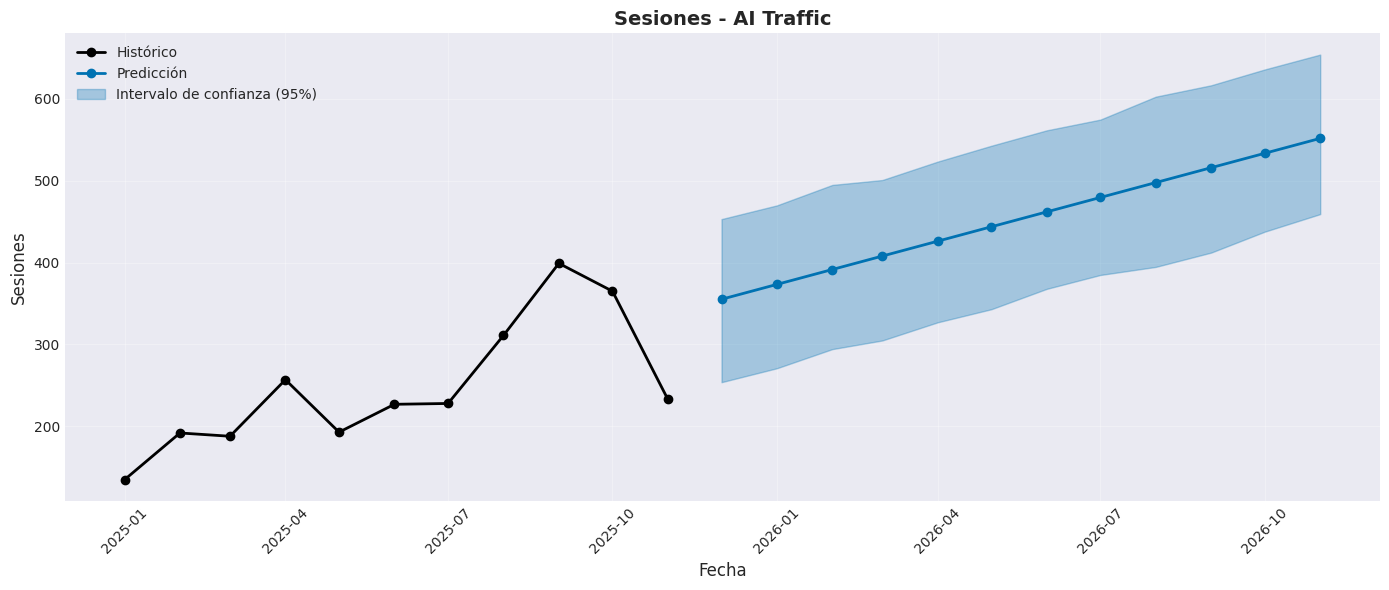

   Gráfico: bounce_rate


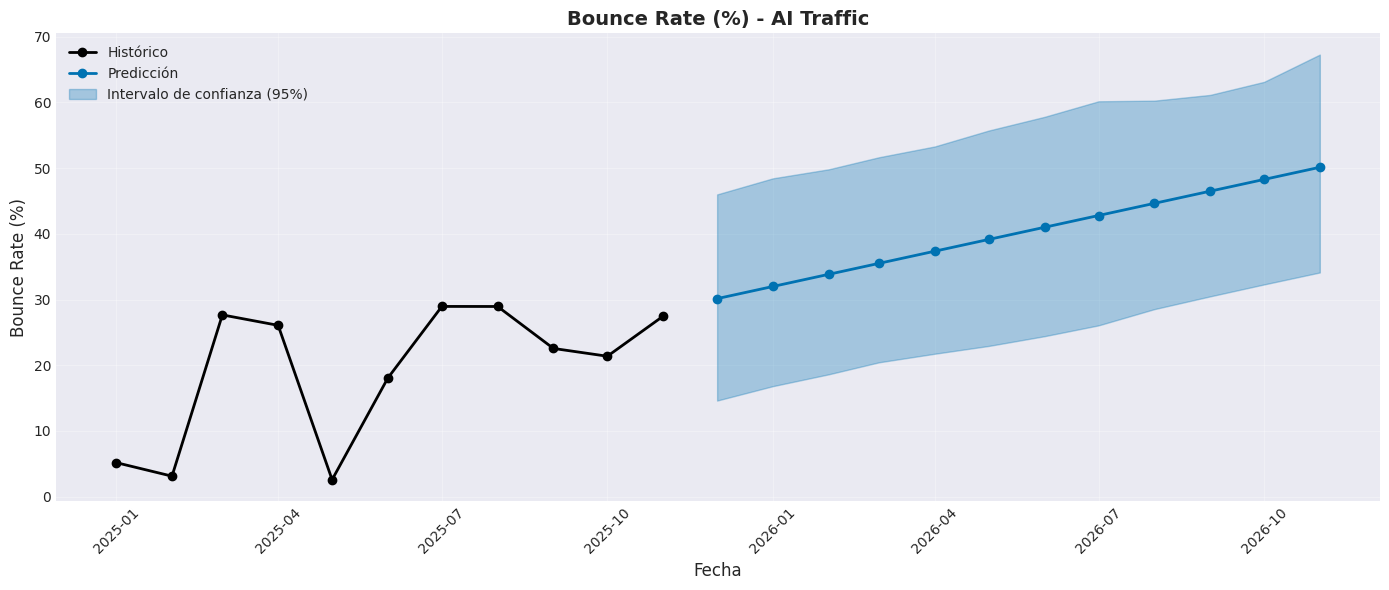

   Gráfico: views_per_session


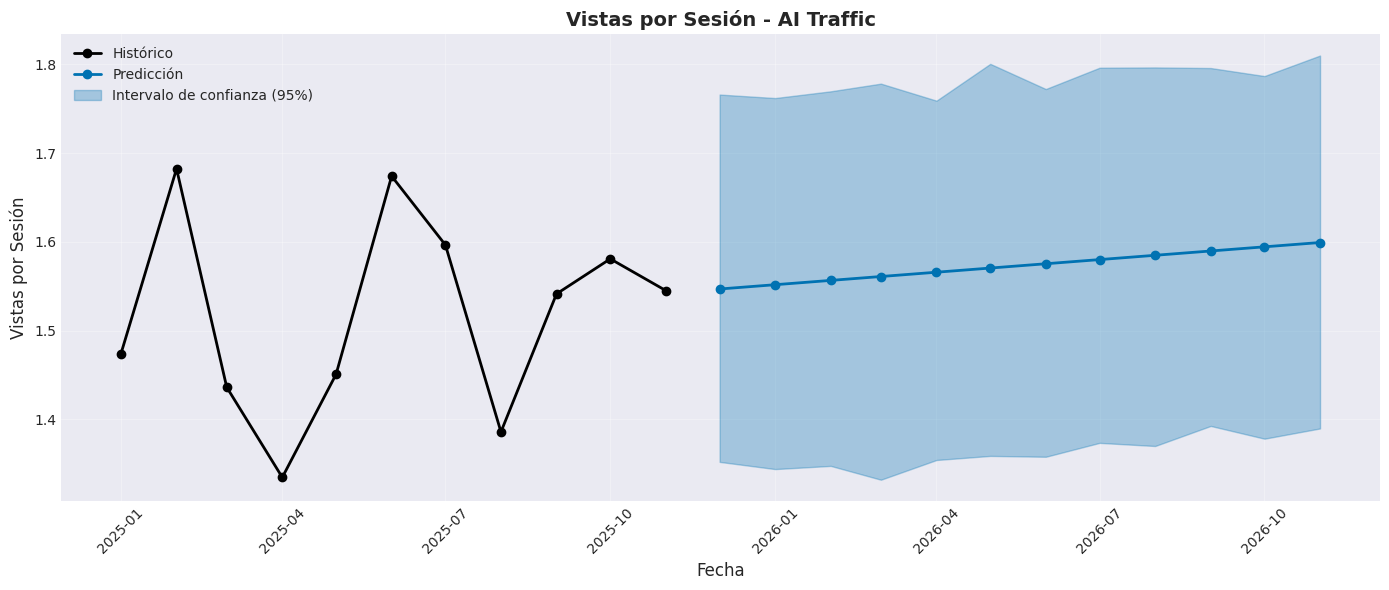

   Gráfico: avg_session_duration


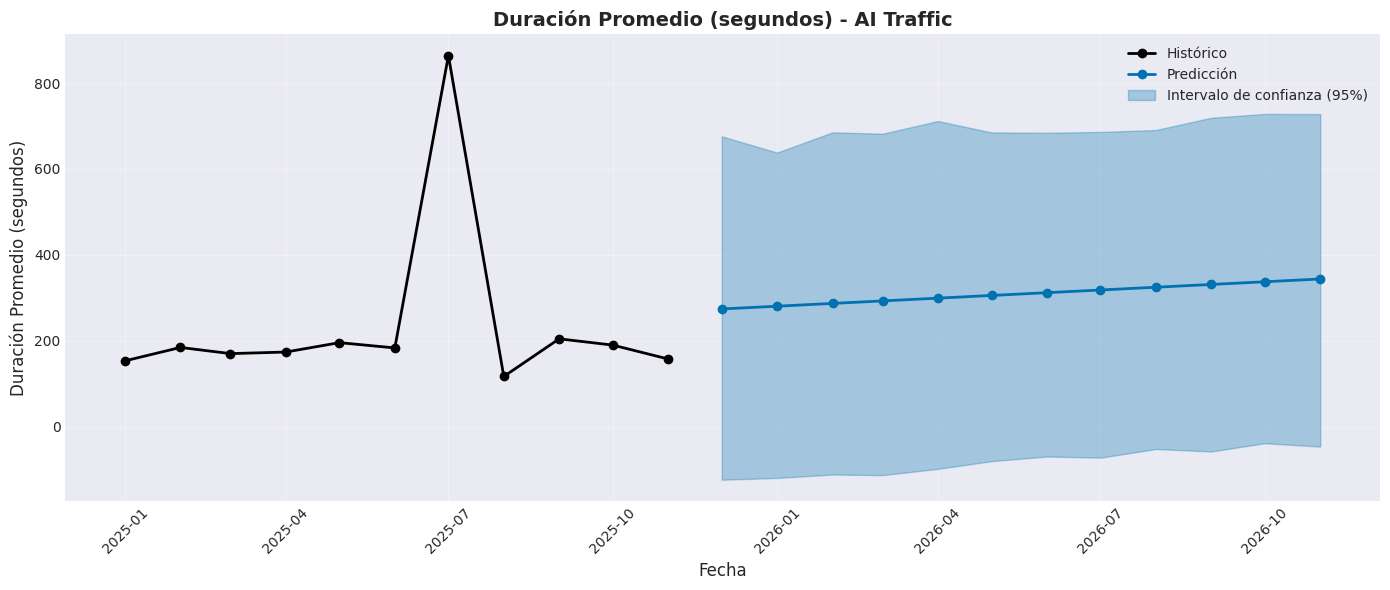


📈 Canal: Organic Search
----------------------------------------------------------------------
   Gráfico: sessions


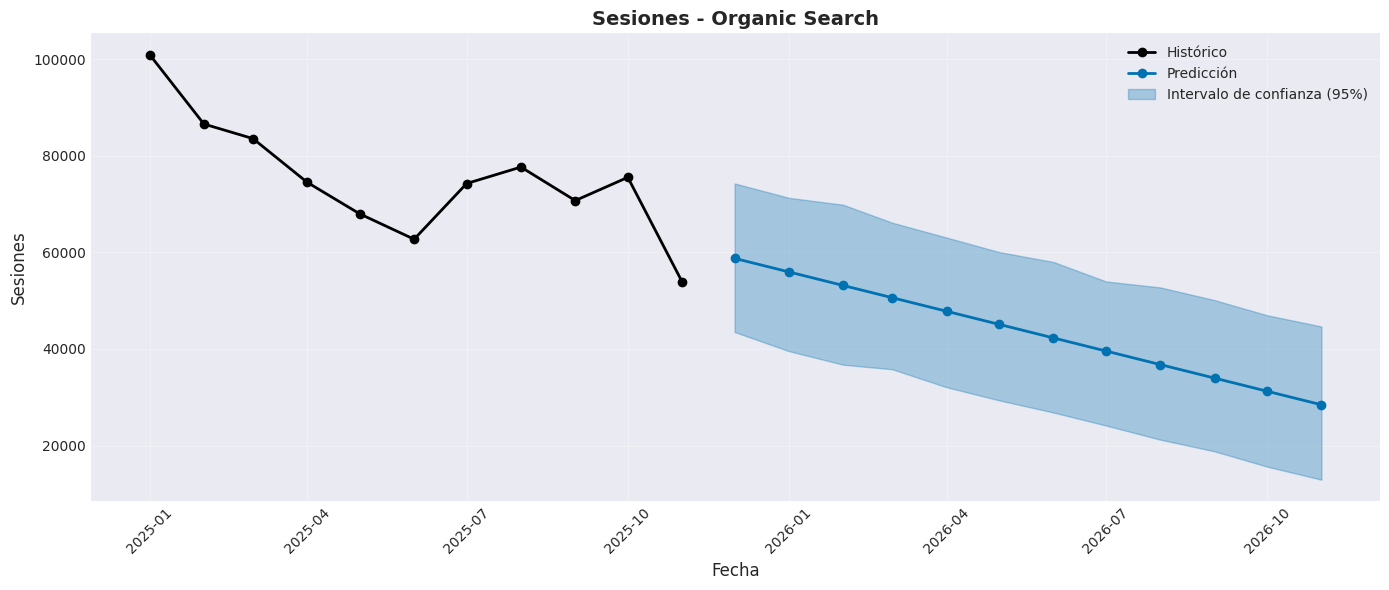

   Gráfico: bounce_rate


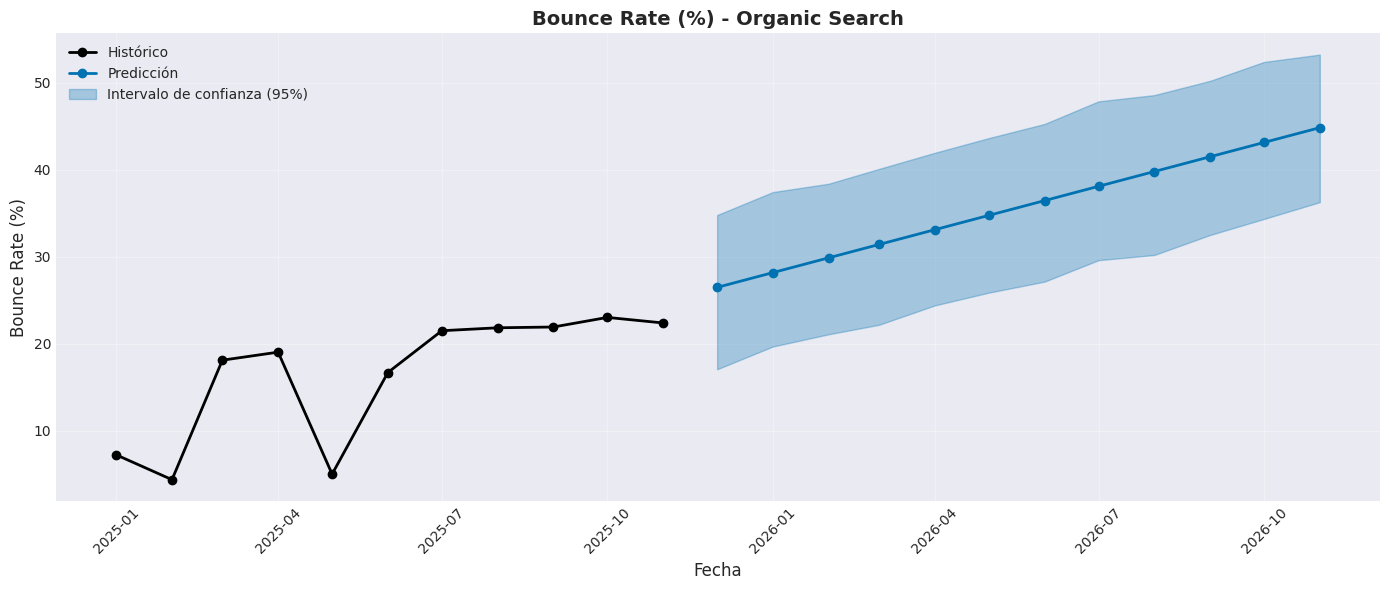

   Gráfico: views_per_session


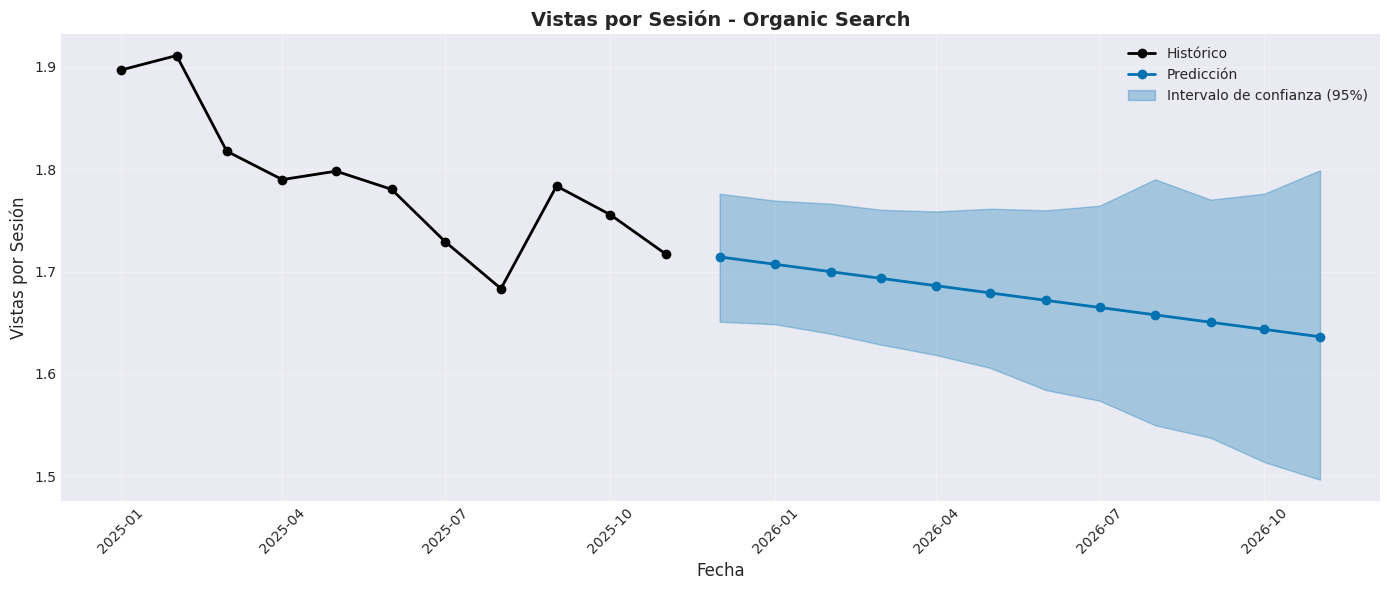

   Gráfico: avg_session_duration


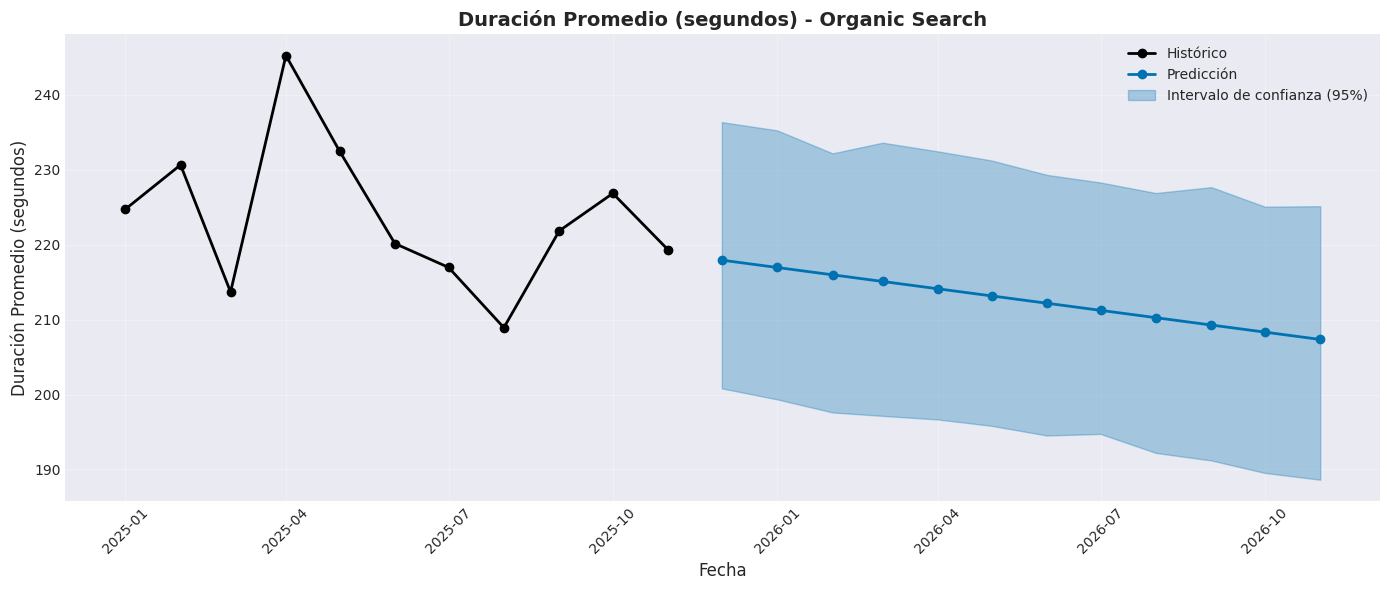


✅ 8 gráficos generados y guardados en: ../results/figures/forecasts


In [53]:
# Generar gráficos para todas las combinaciones
print("📊 Generando visualizaciones de predicciones...\n")

graficos_generados = []

for canal in canales:
    print(f"\n📈 Canal: {canal}")
    print("-" * 70)
    
    df_canal = df[df['channel'] == canal].sort_values('ds')
    
    for metrica in metricas_forecast:
        print(f"   Gráfico: {metrica}")
        
        forecast = resultados_forecasts[canal][metrica]
        titulo = metricas_titulos[metrica]
        
        filename = plot_forecast(df_canal, forecast, canal, metrica, titulo)
        graficos_generados.append(filename)

print(f"\n✅ {len(graficos_generados)} gráficos generados y guardados en: {RESULTS_FIGURES}")

## 9. Exportación de predicciones 2026

Consolidaremos todas las predicciones en un único dataset.

In [54]:
# Extraer solo las predicciones de 2026
predicciones_2026 = []

for canal in canales:
    for metrica in metricas_forecast:
        forecast = resultados_forecasts[canal][metrica]
        
        # Filtrar solo fechas de 2026
        forecast_2026 = forecast[forecast['ds'].dt.year == 2026][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
        
        # Agregar información del canal y métrica
        forecast_2026['channel'] = canal
        forecast_2026['metric'] = metrica
        forecast_2026['year'] = 2026
        forecast_2026['month'] = forecast_2026['ds'].dt.month
        
        # Renombrar columnas
        forecast_2026 = forecast_2026.rename(columns={
            'yhat': 'predicted_value',
            'yhat_lower': 'lower_bound',
            'yhat_upper': 'upper_bound'
        })
        
        predicciones_2026.append(forecast_2026)

# Consolidar en un DataFrame
df_predicciones = pd.concat(predicciones_2026, ignore_index=True)

# Reordenar columnas
df_predicciones = df_predicciones[[
    'year', 'month', 'channel', 'metric', 
    'predicted_value', 'lower_bound', 'upper_bound', 'ds'
]].sort_values(['channel', 'metric', 'year', 'month']).reset_index(drop=True)

print("📊 Predicciones 2026 consolidadas:\n")
print(f"Total de predicciones: {len(df_predicciones)}")
print(f"\nPrimeras filas:")
display(df_predicciones.head(15))

📊 Predicciones 2026 consolidadas:

Total de predicciones: 88

Primeras filas:


,year,month,channel,metric,predicted_value,lower_bound,upper_bound,ds
0,2026,1,AI Traffic,avg_session_duration,280.22,-119.83,637.97,2026-01-01
1,2026,2,AI Traffic,avg_session_duration,286.69,-111.94,685.23,2026-02-01
2,2026,3,AI Traffic,avg_session_duration,292.52,-113.28,681.94,2026-03-01
3,2026,4,AI Traffic,avg_session_duration,298.99,-98.63,711.54,2026-04-01
4,2026,5,AI Traffic,avg_session_duration,305.24,-80.72,685.01,2026-05-01
5,2026,6,AI Traffic,avg_session_duration,311.70,-69.97,684.26,2026-06-01
6,2026,7,AI Traffic,avg_session_duration,317.96,-72.50,686.07,2026-07-01
7,2026,8,AI Traffic,avg_session_duration,324.42,-52.47,690.69,2026-08-01
8,2026,9,AI Traffic,avg_session_duration,330.88,-58.20,719.12,2026-09-01
9,2026,10,AI Traffic,avg_session_duration,337.14,-38.96,728.08,2026-10-01


In [55]:
# Guardar predicciones en CSV
forecast_file = DATA_FORECASTS / 'forecasts_2026_all_channels.csv'
df_predicciones.to_csv(forecast_file, index=False)

print(f"✅ Predicciones guardadas en: {forecast_file}")
print(f"📊 Dimensiones: {df_predicciones.shape[0]} filas x {df_predicciones.shape[1]} columnas")
print(f"💾 Tamaño: {forecast_file.stat().st_size / 1024:.2f} KB")

✅ Predicciones guardadas en: ../data/forecasts/forecasts_2026_all_channels.csv
📊 Dimensiones: 88 filas x 8 columnas
💾 Tamaño: 8.79 KB


## 10. Resumen ejecutivo de predicciones

In [56]:
# Crear resumen por canal y métrica (promedio anual 2026)
resumen_2026 = df_predicciones.groupby(['channel', 'metric']).agg({
    'predicted_value': ['mean', 'sum', 'min', 'max'],
    'lower_bound': 'mean',
    'upper_bound': 'mean'
}).round(2)

print("📊 Resumen de predicciones 2026 por canal y métrica:\n")
display(resumen_2026)

📊 Resumen de predicciones 2026 por canal y métrica:



predicted_value                     \
                                               mean       sum      min   
channel        metric                                                    
AI Traffic     avg_session_duration          311.76   3429.36   280.22   
               bounce_rate                    41.00    451.05    31.98   
               sessions                      461.98   5081.83   373.31   
               views_per_session               1.58     17.33     1.55   
Organic Search avg_session_duration          212.18   2333.97   207.35   
               bounce_rate                    36.48    401.27    28.18   
               sessions                    42264.09 464904.99 28441.68   
               views_per_session               1.67     18.39     1.64   

                                             lower_bound upper_bound  
                                         max        mean        mean  
channel        metric                                                 
AI Traffic     avg_session_duration   343.60      -78.48      694.33  
               bounce_rate             50.11       25.13       57.14  
               sessions               551.51      363.31      561.33  
               views_per_session        1.60        1.36        1.78  
Organic Search avg_session_duration   216.96      194.31      229.74  
               bounce_rate             44.85       27.58       45.39  
               sessions             55954.86    26642.84    57906.90  
               views_per_session        1.71        1.58        1.77

In [57]:
# Guardar resumen ejecutivo
resumen_file = RESULTS_REPORTS / 'summary_forecasts_2026.csv'
resumen_2026.to_csv(resumen_file)
print(f"\n💾 Resumen ejecutivo guardado en: {resumen_file}")


💾 Resumen ejecutivo guardado en: ../results/reports/summary_forecasts_2026.csv


In [58]:
# Resumen final
print("="*70)
print("🎯 RESUMEN FINAL DEL FORECASTING")
print("="*70)

print(f"\n1. MODELOS ENTRENADOS:")
print(f"   - Total de modelos: {len(canales) * len(metricas_forecast)}")
print(f"   - Canales analizados: {len(canales)}")
print(f"   - Métricas predichas: {len(metricas_forecast)}")

print(f"\n2. PERÍODO DE PREDICCIÓN:")
print(f"   - Horizonte: 12 meses (2026)")
print(f"   - Desde: Enero 2026")
print(f"   - Hasta: Diciembre 2026")

print(f"\n3. ARCHIVOS GENERADOS:")
print(f"   - Predicciones completas: {forecast_file.name}")
print(f"   - Resumen ejecutivo: {resumen_file.name}")
print(f"   - Métricas de evaluación: {eval_file.name}")
print(f"   - Gráficos: {len(graficos_generados)} archivos PNG")

print(f"\n4. MÉTRICAS PREDICHAS:")
for metrica in metricas_forecast:
    print(f"   - {metrica}")

print(f"\n5. PRÓXIMO PASO:")
print(f"   ✓ Notebook 04: Visualización y análisis de resultados")
print(f"   ✓ Generación de reportes ejecutivos")
print(f"   ✓ Exportación de dashboards")

print("\n" + "="*70)

🎯 RESUMEN FINAL DEL FORECASTING

1. MODELOS ENTRENADOS:
   - Total de modelos: 8
   - Canales analizados: 2
   - Métricas predichas: 4

2. PERÍODO DE PREDICCIÓN:
   - Horizonte: 12 meses (2026)
   - Desde: Enero 2026
   - Hasta: Diciembre 2026

3. ARCHIVOS GENERADOS:
   - Predicciones completas: forecasts_2026_all_channels.csv
   - Resumen ejecutivo: summary_forecasts_2026.csv
   - Métricas de evaluación: model_evaluation_metrics.csv
   - Gráficos: 8 archivos PNG

4. MÉTRICAS PREDICHAS:
   - sessions
   - bounce_rate
   - views_per_session
   - avg_session_duration

5. PRÓXIMO PASO:
   ✓ Notebook 04: Visualización y análisis de resultados
   ✓ Generación de reportes ejecutivos
   ✓ Exportación de dashboards



---

## Notas importantes:

### Sobre Prophet:
- ✅ Modelo automático de Facebook optimizado para series temporales
- ✅ Genera intervalos de confianza del 95%
- ✅ Robusto con datos faltantes y outliers
- ⚠️ Con solo 11 meses de histórico, la precisión puede ser limitada

### Sobre las predicciones:
- Las predicciones deben interpretarse como **estimaciones** basadas en tendencias históricas
- Los intervalos de confianza indican el rango probable de valores
- Eventos externos (cambios de algoritmo, estacionalidad no capturada) pueden afectar la precisión

### Métricas de evaluación:
- **MAE** (Mean Absolute Error): Error promedio absoluto
- **RMSE** (Root Mean Squared Error): Error cuadrático medio
- **MAPE** (Mean Absolute Percentage Error): Error porcentual promedio

## ✅ Archivos generados:

- `data/forecasts/forecasts_2026_all_channels.csv` - Predicciones completas
- `results/reports/summary_forecasts_2026.csv` - Resumen ejecutivo
- `results/reports/model_evaluation_metrics.csv` - Métricas de evaluación
- `results/figures/forecasts/*.png` - Gráficos de predicciones

## Próximo paso:

**Notebook 04:** Visualización avanzada y reportes finales